In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
tqdm.pandas()
sns.set_context("paper")

In [2]:
path_to_base_results: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr/ppl/starr/val/'
file_name: str = 'train-tokens-total_nonPAD-true_val=2400000000-ckpt_val=2400000000-persist'
N_SPECIAL_TOKENS: int = 7 # number of special tokens in tokenizer (useful for offseting to realign with original CLMBR vocab)

# Stability of Calculating PPL v. # Patients Sampled

How stable is our estimate of val/ppl v. number of patients?

**Experiment:**
* Calculate val/ppl for same model across 1k, 5k, 10k, 20k val patients and measure deviation.

NOTE: It takes ~2.5 hrs for 10k patients.

Run these commands to generate results used in this section:

```bash
# Stability of PPL
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 1000 # 0.1 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 5000 # 0.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 10000 # 2.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 50000 # 5.5 hrs
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr --stride 32 --n_patients 100000
```

In [3]:
def print_percentiles(values: pd.Series):
    percentiles = [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 95, 99, 100]
    percentile_values = np.percentile(values, percentiles)
    df_percentiles = pd.DataFrame({
        'percentile': percentiles,
        'value': percentile_values
    })
    with pd.option_context('display.float_format', lambda x: '%.3f' % x):
        print("==== Percentiles ====")
        print(df_percentiles)

def calculate_ppl_per_token_pos(df: pd.DataFrame, min_token_count: int = 30) -> pd.DataFrame:
    """Calculate token position v. median val/ppl"""

    # Count token position frequencies
    df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index()

    # Filter out any token positions with < min_token_count occurrences
    keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_token_count]['token_idx'].tolist()
    print(f"Keeping {len(keep_token_idxs)} token positions (i.e. all token positions with >= {min_token_count} data points)")

    df_pos_to_ppl = []
    for token_idx in tqdm(keep_token_idxs, desc='Processing token positions'):
        # 1. Calculate median PPL for this token positions
        df_token_idx = df[df['token_idx'] == token_idx]
        median = df_token_idx['label_ppl'].median()
        # 2. Calculate 95% CI
        # Sort the data
        sorted_data = df_token_idx['label_ppl'].sort_values().values
        n = len(sorted_data)
        # Calculate the ranks for the 95% confidence interval
        lower_rank = int(np.floor(0.5 * n - 1.96 * np.sqrt(n) / 2))
        upper_rank = int(np.ceil(0.5 * n + 1.96 * np.sqrt(n) / 2))
        lower_rank = max(0, lower_rank)
        upper_rank = min(n - 1, upper_rank)
        lower_bound = sorted_data[lower_rank]
        upper_bound = sorted_data[upper_rank]
        df_pos_to_ppl.append({
            'token_idx': token_idx,
            'median': median,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })
    df_pos_to_ppl = pd.DataFrame(df_pos_to_ppl)
    df_pos_to_ppl['ema_median'] = df_pos_to_ppl['median'].ewm(span=20, adjust=False).mean()
    return df_pos_to_ppl

def plot_token_idx_v_ppl(df_pos_to_ppl: pd.DataFrame, ctx_length: int, is_use_ema: bool = False, is_show_ci: bool = False, is_zoom_to_ctx: bool = False):
    """Plot token position v. median PPL"""
    assert 'token_idx' in df_pos_to_ppl.columns, "token_idx column not found in df_pos_to_ppl"
    assert 'lower_bound' in df_pos_to_ppl.columns, "lower_bound column not found in df_pos_to_ppl"
    assert 'upper_bound' in df_pos_to_ppl.columns, "upper_bound column not found in df_pos_to_ppl"
    plt.figure(figsize=(6, 4))
    if is_use_ema:
        # Use exponential moving average of median PPL
        assert 'ema_median' in df_pos_to_ppl.columns, "ema_median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['ema_median'], label='Median PPL (EMA)')
    else:
        # Use raw median PPL
        assert 'median' in df_pos_to_ppl.columns, "median column not found in df_pos_to_ppl"
        plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
    if is_show_ci:
        plt.fill_between(df_pos_to_ppl['token_idx'], df_pos_to_ppl['lower_bound'], df_pos_to_ppl['upper_bound'], alpha=0.3, color='green', label='95% CI')
    plt.xlabel('Token position')
    plt.ylabel('Median PPL')
    plt.title('Token position v. Median PPL' + (' (EMA)' if is_use_ema else ''))
    plt.axvline(x=ctx_length-1, color='red', linestyle='--', label=f'ctx length = {ctx_length}')
    if is_zoom_to_ctx:
        plt.xlim(-10, ctx_length + 100)
        plt.ylim(2, 8)
    plt.legend()
    plt.show()

# How does ctxt length affect PPL?

Run these commands to generate the results used in this section:

```bash
# PPL across ctx lengths
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-2048--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-4096--clmbr --stride 32 --n_patients 10000
python3 val_ppl.py --path_to_ckpt_dir /share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-512--clmbr --stride 32 --n_patients 10000
```

**Experiment:**
* Run `gpt-base-k--clmbr` models on the same set of validation patients, with $k \in \{512, 1k, 2k, 4k\}$. Measure the overall ppl for each model.

In [4]:
df_ctxs = {}
for k in [ 512, 1024, 2048, 4096 ]:
    path_to_base_results: str = f'/share/pi/nigam/suhana/hf_ehr/cache/runs_backup/gpt-{k}-rope-rebuttal/ppl/starr/val'
    path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=20000-is_config=False')
    file_name = [ x for x in os.listdir(path_to_10k) if x.endswith('.parquet') ][0]
    df_ctxs[k] = pd.read_parquet(os.path.join(path_to_10k, file_name))
    print(f"Loaded {k} with shape={df_ctxs[k].shape}")

Loaded 512 with shape=(13835144, 14)
Loaded 1024 with shape=(13835144, 14)
Loaded 2048 with shape=(13835144, 14)
Loaded 4096 with shape=(13835144, 14)


In [6]:
# Calculate median PPL per token position
df_ctxs__pos_to_ppl = {}
for k in df_ctxs.keys():
    if k not in df_ctxs__pos_to_ppl:
        df_ctxs__pos_to_ppl[k] = calculate_ppl_per_token_pos(df_ctxs[k])
        df_ctxs__pos_to_ppl[k]['ema_median'] = df_ctxs__pos_to_ppl[k]['median'].ewm(span=20, adjust=False).mean()
    else:
        print(f"Skipping {k}")

Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:27<00:00, 70.50it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:31<00:00, 69.87it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:26<00:00, 70.80it/s]


Keeping 31579 token positions (i.e. all token positions with >= 30 data points)


Processing token positions: 100%|██████████| 31579/31579 [07:30<00:00, 70.07it/s]


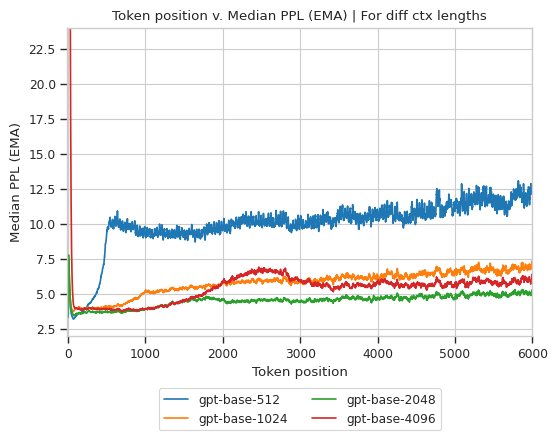

In [11]:
# Show all on same plot
plt.figure(figsize=(6, 4))
for k in df_ctxs__pos_to_ppl.keys():
    plt.plot(df_ctxs__pos_to_ppl[k]['token_idx'], df_ctxs__pos_to_ppl[k]['ema_median'], label=f'gpt-base-{k}')
plt.xlabel('Token position')
plt.ylabel('Median PPL (EMA)')
plt.title('Token position v. Median PPL (EMA) | For diff ctx lengths')
plt.xlim(-10, 6000)
plt.ylim(2, 24)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [9]:
# Plot PPL for first k tokens across diff models
token_span_start, token_span_end = 0, 4096
df_r = []
valid_pids = df_ctxs[512]['pid'].value_counts()[df_ctxs[512]['pid'].value_counts() >= token_span_end].index # only keep pids that have at least `token_span_end` tokens
for k in df_ctxs.keys():
    df_ = df_ctxs[k]
    # Filter to valid pids
    df_ = df_[df_['pid'].isin(valid_pids)]
    assert df_['pid'].nunique() == len(valid_pids), f"Not all pids were found for k={k}"
    # Calculate PPL for first k tokens
    ppl = np.exp(-df_[(token_span_start <= df_['token_idx']) & (df_['token_idx'] <= token_span_end)]['label_log_prob'].mean())
    df_r.append({
        'ctx_length': k,
        'ppl': ppl
    })
df_r = pd.DataFrame(df_r)
df_r

,ctx_length,ppl
0,512,16.923810
1,1024,10.214572
2,2048,7.963711
3,4096,9.434160


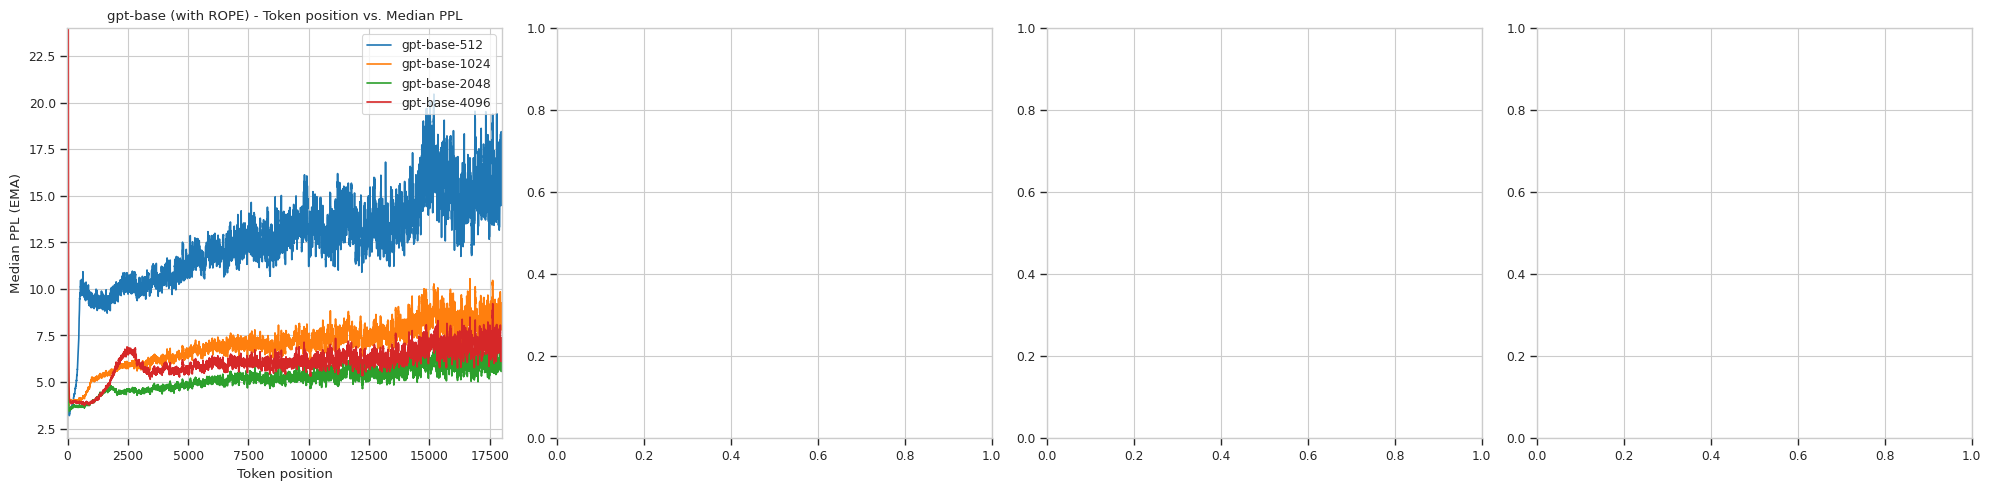

In [10]:
# Set the Seaborn theme
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
})  

max_x = {
    'gpt-base': 24,
    'mamba-tiny': 7.5,
    'hyena-large': 7.5,
    'llama-base': 7.5
}
tab10_colors = sns.color_palette("tab10")
models = ['gpt-base', ] # 'hyena-large', 'llama-base', 'mamba-tiny']
context_lengths = [512, 1024, 2048, 4096, 8192, 16384]

df_models__pos_to_ppl = {
    ('gpt-base', 512): df_ctxs__pos_to_ppl[512],
    ('gpt-base', 1024): df_ctxs__pos_to_ppl[1024],
    ('gpt-base', 2048): df_ctxs__pos_to_ppl[2048],
    ('gpt-base', 4096): df_ctxs__pos_to_ppl[4096],
}
# Create subplots (2x2 grid)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easy iteration

for m_idx, m in enumerate(models):
    ax = axes[m_idx]  # Select the subplot axis
    color_id = 0
    for k_idx, k in enumerate(context_lengths):
        if (m, k) not in df_models__pos_to_ppl:
            continue
        color = tab10_colors[color_id]
        color_id += 1
        # Plot the data for the current model and context length using Seaborn
        sns.lineplot(x=df_models__pos_to_ppl[(m, k)]['token_idx'],
                     y=df_models__pos_to_ppl[(m, k)]['ema_median'],
                     label=f'{m}-{k}', ax=ax, color=color)

    # Set labels, title, and limits for each subplot
    ax.set_xlabel('Token position')
    ax.set_ylabel('Median PPL (EMA)')
    ax.set_title(f'{m} (with ROPE) - Token position vs. Median PPL')
    ax.set_xlim(-10, 18000)
    ax.set_ylim(2, max_x[m])
    ax.legend(loc='upper right')

# Adjust layout to ensure plots don't overlap
plt.tight_layout()
plt.show()

# 